In [18]:
import gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter

In [2]:
np.random.seed(2)
# 1, 300 steps --> found after ~ 50 steps, 150 steps --> found after ~ 50 steps
# 2, 300 steps --> ..., 150 steps --> found after ~ 50 steps
# 3, 300 steps --> ..., 150 steps --> ...
# 4, 300 steps --> ..., 150 steps --> ...
# 5
# 6
# 7
# 8

In [3]:
torch.cuda.is_available()

False

In [4]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [5]:
env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=1e-2,
                   sample_pars=False,
                   pars={'store_raw': False,
                         'max_buffer_len': 1e4,
                         'tpa_queue': [1],
                         'pileup_prob': 0.,
                         'xi': np.array([1e2])},
               render_mode='human',
                   )

In [6]:
obs, info = env.reset()

In [7]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=1e-3, buffer_size=1e4, learning_starts=0,
                        batch_size=16, gamma=.6, gradient_steps=100, 
                        device='cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [9]:
model.learn(episodes = 1, 
            episode_steps = 150, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

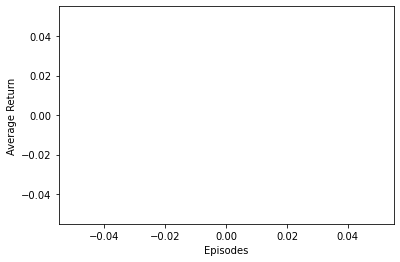

In [10]:
tracker.plot(smooth=1)

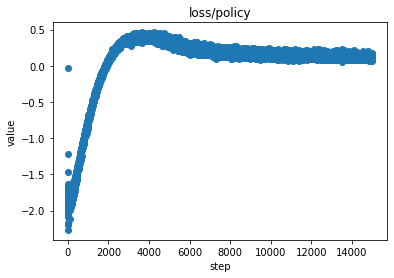

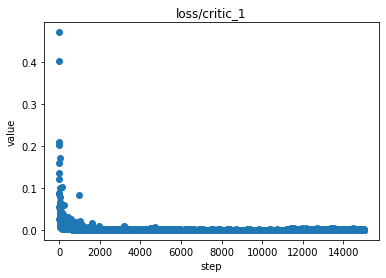

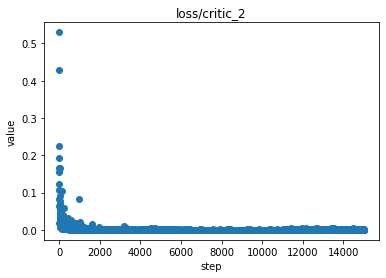

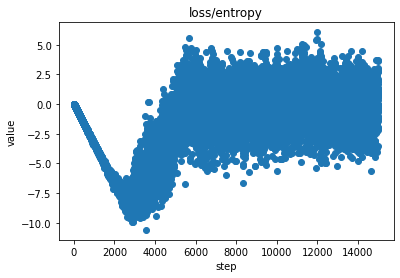

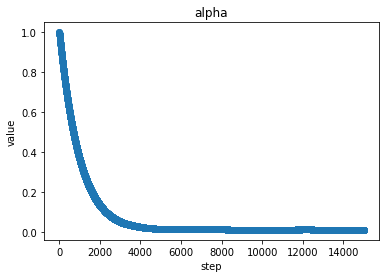

In [11]:
for key in writer.history.keys():
    writer.plot(key)

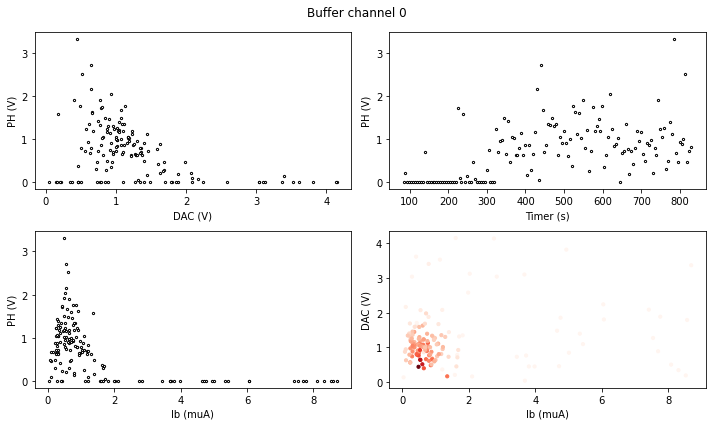

In [12]:
env.detector.plot_buffer()

  0%|          | 0/10 [00:00<?, ?it/s]

[[-0.23226476 -0.94055283]]
[-0.99141533 -0.9999886  -0.94055283 -0.23226476] -0.0072570401683997934


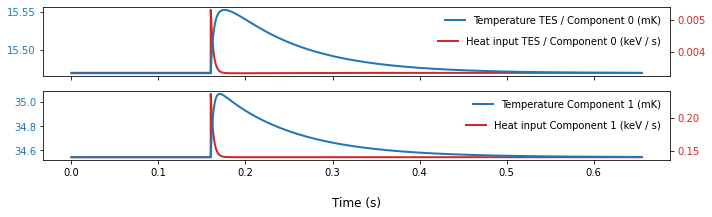

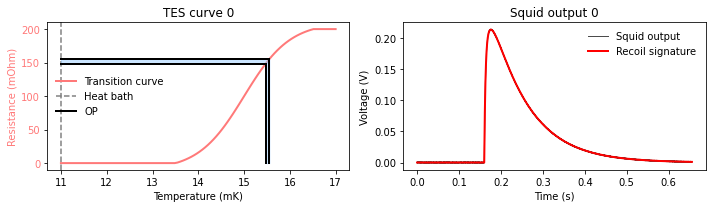

[[-0.6817699  -0.89695907]]
[-0.97082984 -0.99998739 -0.89695907 -0.68176991] -0.0024719339611772467


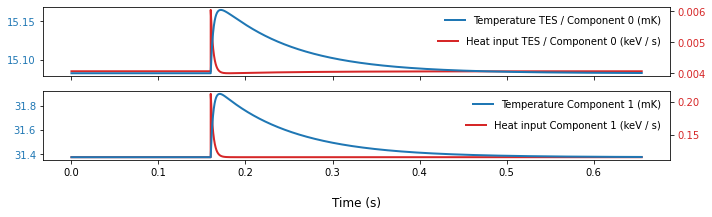

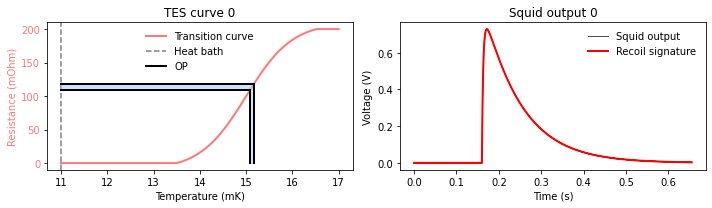

[[-0.48863065 -0.9177529 ]]
[-0.97487306 -0.99998737 -0.91775292 -0.48863065] -0.0008798754014914168


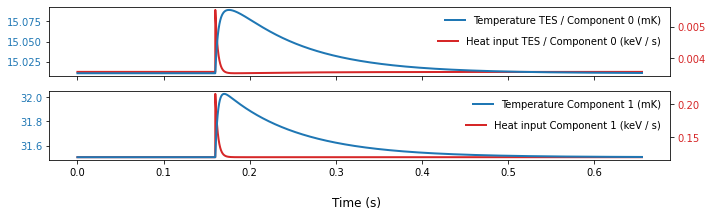

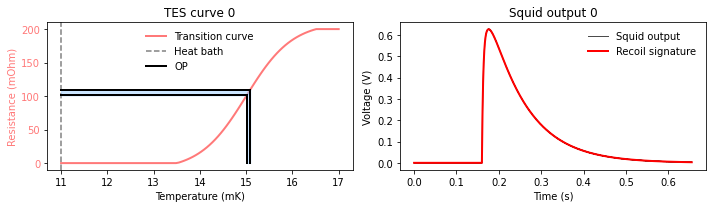

[[-0.5900212 -0.8974791]]
[-0.96580082 -0.99998693 -0.89747912 -0.59002119] -0.0004891451985137505


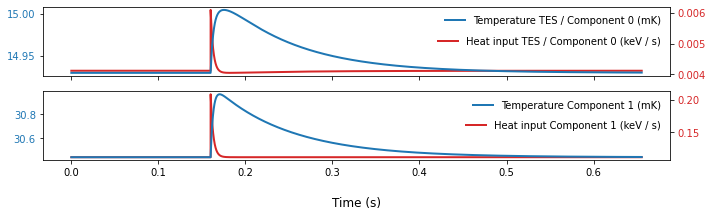

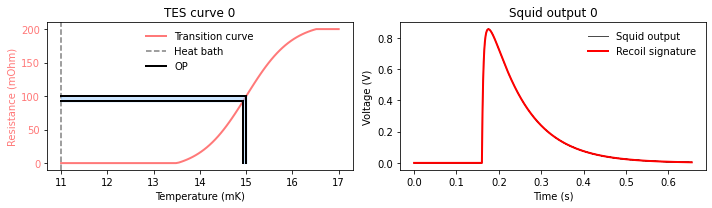

[[-0.5402146  -0.90833545]]
[-0.96575712 -0.99998621 -0.90833545 -0.5402146 ] -0.00042879659433735706


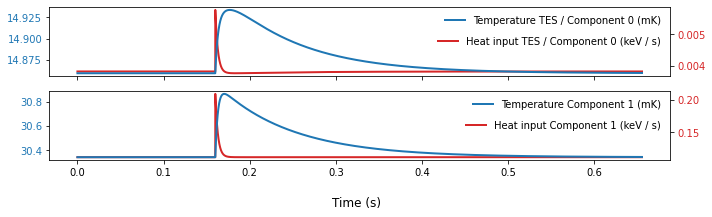

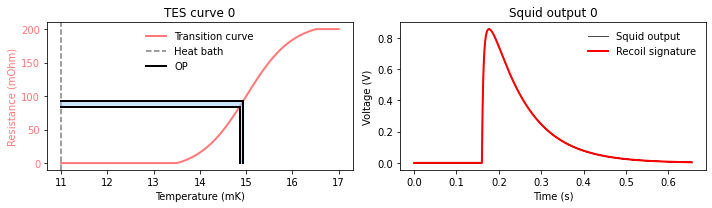

[[-0.564862   -0.90216815]]
[-0.96292877 -0.99998653 -0.90216815 -0.56486201] -0.0003699147637144759


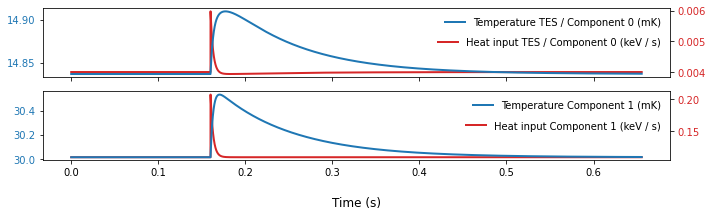

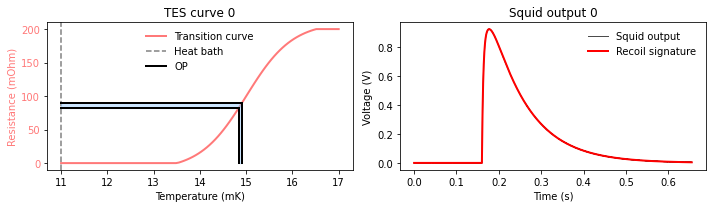

[[-0.55230284 -0.9050087 ]]
[-0.96256622 -0.99998627 -0.90500867 -0.55230284] -0.00036841491170845365


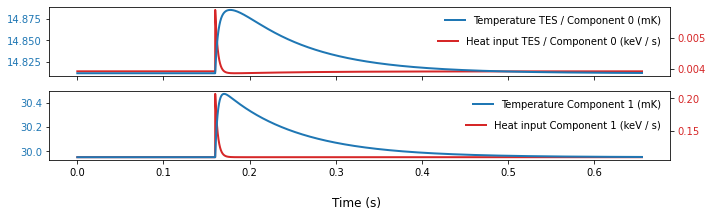

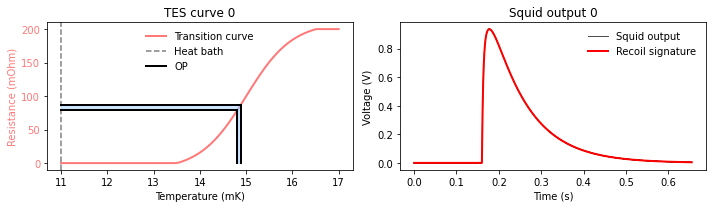

[[-0.5583671 -0.9034166]]
[-0.9616927  -0.99998626 -0.90341657 -0.55836707] -0.00035900724359115696


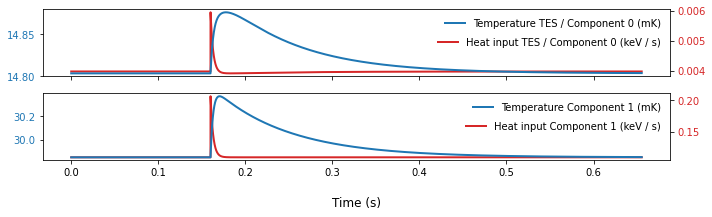

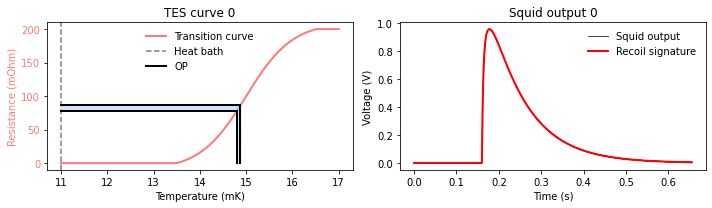

[[-0.55524373 -0.90409756]]
[-0.96149506 -0.99998634 -0.90409756 -0.55524373] -0.0003549139097192851


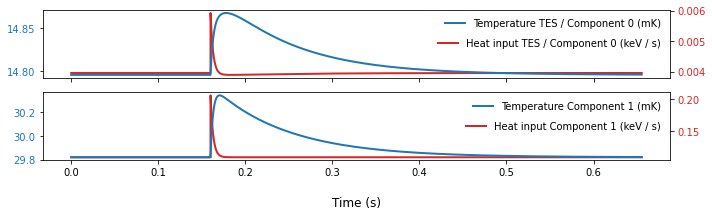

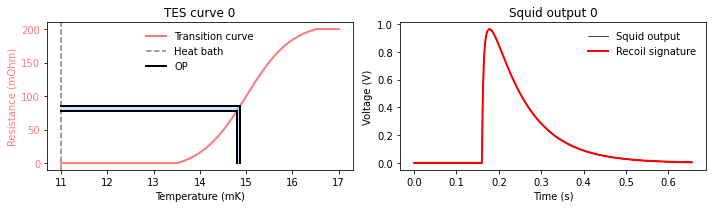

[[-0.55671513 -0.9036982 ]]
[-0.961215   -0.9999859  -0.90369821 -0.55671513] -0.0003634380688271893


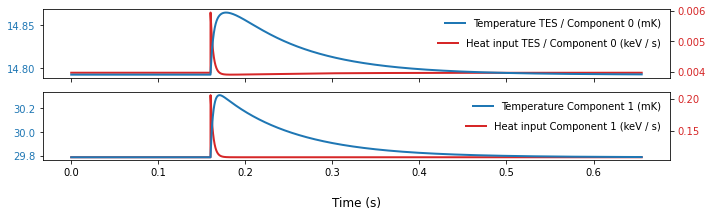

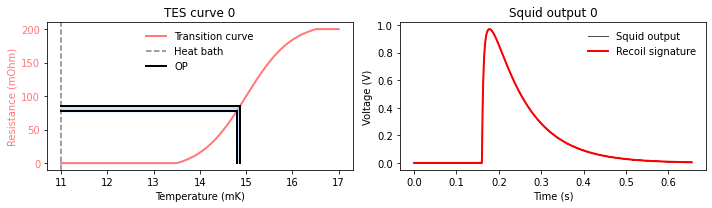

In [13]:
obs, _ = env.reset()
model.policy.eval()
returns = 0
for i in trange(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    print(action)
    print(obs, reward)
    returns += reward
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

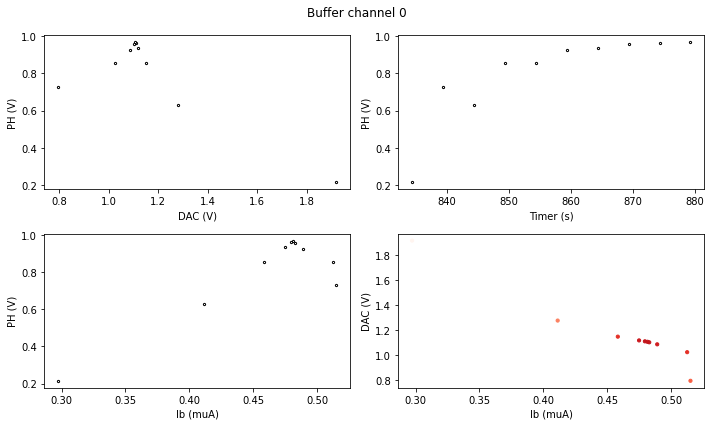

In [14]:
env.detector.plot_buffer()

In [ ]:
env.close()

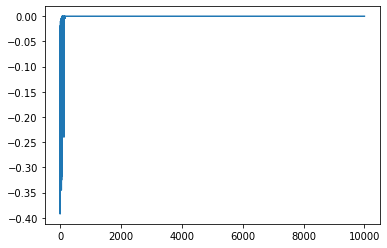

In [21]:
plt.plot(model.buffer.reward_memory)